# The situation

Type C thermocouples are not NIST calibrated to below 273.15 K. For my research specific scenario, I need to cool my sample (Molybdenum) to cryogenic temperatures and also anneal to very high ~2000 K. There is no thermocouple with these properties. 




### The solution

We know that Type K thermocouples are accurate down to cryogenic temperatures. So what I've done here is to read the Type K temperature and record the corresponding Type C mV to create a calibration table. Both thermocouples were spot welded to a large mass very close to one another to ensure the temperature readings will be accurate.

Then I will use a polynomial fit to get the low T calibration for the Type C thermocouple.

In [1]:
# import a few packages
%matplotlib notebook
from thermocouples_reference import thermocouples
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
from scipy import optimize, interpolate, signal


typeC=thermocouples['C']

In [2]:
# make sure you are in the same dir as the file
# read in the file and drop Na cols
df = pd.read_excel('Type C Table 4-2-18.xlsx')
df.dropna(axis=1, inplace=True)
df.head()

,T,TypeKmV,CJC,TypeCmV
0,295.68,0.90,25.27,0.021
1,292.79,0.78,25.27,-0.017
2,292.04,0.74,25.26,-0.028
3,291.22,0.72,25.26,-0.037
4,290.56,0.69,25.26,-0.045


In [3]:
# NIST has values calibrated for T > 273.15 K, lets find the Tref based on these points
# I am using Kelvin for all T. The CJC is quoted in deg C.
tempdf = df.query('T>273.15')
tempdf.head()

,T,TypeKmV,CJC,TypeCmV
0,295.68,0.90,25.27,0.021
1,292.79,0.78,25.27,-0.017
2,292.04,0.74,25.26,-0.028
3,291.22,0.72,25.26,-0.037
4,290.56,0.69,25.26,-0.045


In [4]:
# Let's find the T_ref by using this function to take the TypeC mV and the T to find the Tref
def find_Tref(mV, T):
    x = np.arange(290, 301, 0.01)
    x = x[::-1] # lets reverse x
    i = 1
    while typeC.inverse_KmV(mV, Tref=x[i]) - T >= 0:
        i += 1
#     print(x[i])
    return x[i]

In [5]:
# This isn't the fastest way to do things, but since its just a short amount of rows, lets iterate over the mV and T
# to find Tref
Treflist=[]
for idx in tempdf.index:
    # print(idx)
    Treflist.append(find_Tref(mV=tempdf['TypeCmV'][idx], T=tempdf['T'][idx]))


In [6]:
print( ['%0.2f'% x for x in Treflist])

['294.16', '294.01', '294.05', '293.89', '293.81', '293.93', '293.96', '294.15', '294.08', '294.21', '294.18', '294.30', '294.32', '294.24', '294.37', '294.28', '294.38', '294.37', '294.42', '294.42', '294.41', '294.42', '294.54', '294.47', '294.58', '294.48', '294.58', '294.55', '294.65', '294.71', '294.72', '294.60', '294.70', '294.71', '294.68', '294.72', '294.73', '294.81', '294.86', '294.78', '294.83', '294.74', '295.78', '294.98', '295.06', '294.99', '294.99', '294.92', '294.89', '294.95', '295.08', '294.91', '295.03', '295.05', '295.17', '295.11', '295.10', '295.12', '295.16', '295.20', '295.13', '295.19', '295.19', '295.25', '295.26', '295.24']


In [7]:
# now average the Trefs:
avg_Tref = np.mean(Treflist)
print(avg_Tref)
# I will use this Tref for further calcs
Tref_emf = typeC.emf_mVK(avg_Tref)
print(Tref_emf)
# The Tref_emf value is very close to the value in the table at 273.15 K, so we'll use this value to correct the new values
# The value taken at 273.15 K was during the cooling process and is likely to be less accurate than the room temperature value
# across these multiple observations

294.675
0.293743841619


In [8]:
# The emf correction for 273.15 K is then: calibrated_emf = raw_emf + Tref_emf

# Let's add this to the df we initially imported...

df['TypeC_calib_mV'] = df['TypeCmV'] + Tref_emf

df.head()
# Compared to the NIST table, we appear to be off at most a little less than 1 deg K


,T,TypeKmV,CJC,TypeCmV,TypeC_calib_mV
0,295.68,0.90,25.27,0.021,0.314744
1,292.79,0.78,25.27,-0.017,0.276744
2,292.04,0.74,25.26,-0.028,0.265744
3,291.22,0.72,25.26,-0.037,0.256744
4,290.56,0.69,25.26,-0.045,0.248744


In [9]:
# Had we used the CJC temperature as a proxy for room temp, we would've been even more off.
# compare the TypeCmV using Tref = CJC vs using Tref = 294.67:
print(typeC.emf_mVK(291.22, Tref =(25.26+273.15)))
print(typeC.emf_mVK(291.22, Tref =avg_Tref))

-0.0999688432236
-0.0478884150234


<IPython.core.display.Javascript object>


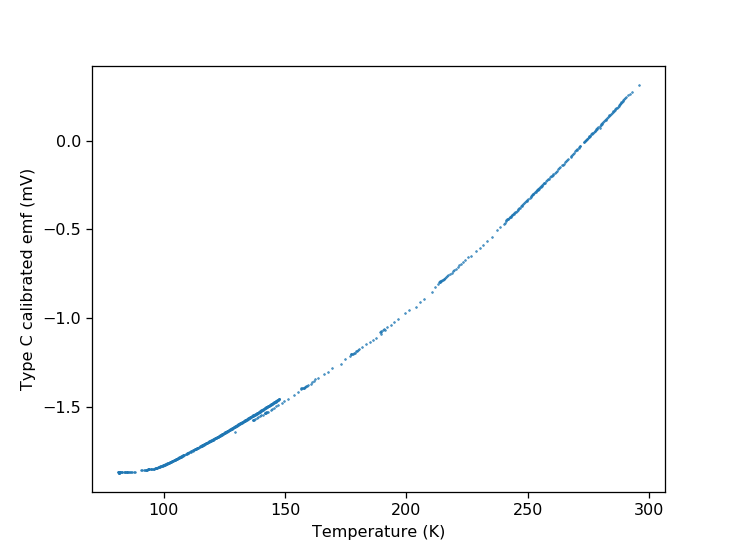

In [10]:
#  Let's visualize these results
plt.plot(df['T'], df['TypeC_calib_mV'], 'o', ms=0.5 )
plt.xlabel('Temperature (K)')
plt.ylabel('Type C calibrated emf (mV)')

# Interesting. I cooled first to LN2 temperatures and then allowed the sample to heat up slowly by evaporating LN2
# The data agrees fairly well (within ~3 K) between the heating and cooling curves. I didn't heat all the way back up.

In [11]:
# Now lets fit the data to a polynowmial using least squares
fit_coeffs = np.polyfit(df['T'],df['TypeC_calib_mV'], deg = 10 , full=True)
# print(fit_coeffs)
fit_poly = np.poly1d(fit_coeffs[0])
print(fit_poly)


            10             9             8             7             6
-2.468e-21 x  + 4.853e-18 x - 4.224e-15 x + 2.138e-12 x - 6.955e-10 x
              5             4            3          2
 + 1.516e-07 x - 2.234e-05 x + 0.002193 x - 0.1365 x + 4.852 x - 76.48


<IPython.core.display.Javascript object>


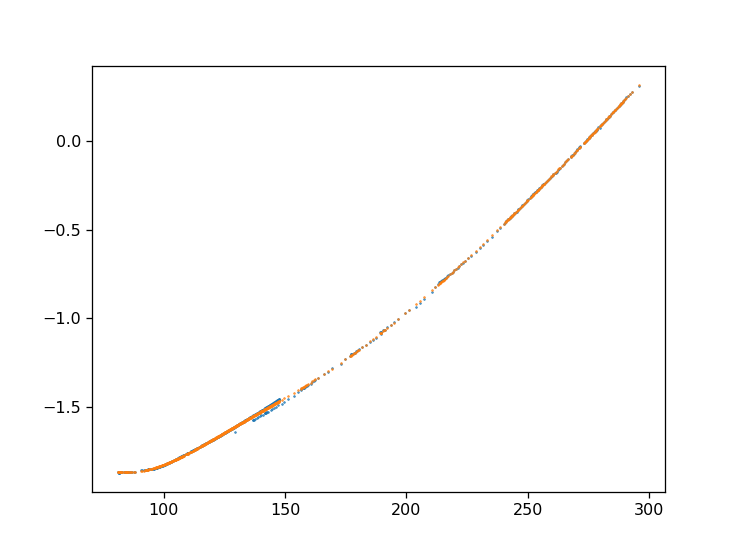

In [12]:
fig, ax = plt.subplots()
ax.plot(df['T'], df['TypeC_calib_mV'],'o',ms='0.5')
ax.plot(df['T'], fit_poly(df['T']) , 'o', ms='0.5')


The 10th degree polynomial appears to give the best fit overall. 
The lower order polynomials dont fit the curve exceedingly well below 100 K

Also, the polynomial tracks the heating curve (the slightly higher mV points from 80-150K) a little more closely than the cooling curve (295 to 80 K). Heating occurred much more slowly than cooling, so I expect it to me more accurate anyways.

In [13]:
# These mV values are also close ~0.5 degrees K of one another
print(fit_poly(273.15))  # fit
print(typeC.emf_mVK(273.15))  # NIST value  

-0.00867236844799
0.0


It's also a good idea to check that the polynomial does not have any inflection points, at least in the area we are interested in using the polynomial (77 K - 273.15 K). We can use the second derivative test to see if this will be important for our case.

In [14]:
x = sp.symbols('x')
polynom = sp.Poly(fit_coeffs[0],x)
# print(fit_coeffs[0])
# find the second derivative of the polynomial
second_derivative = polynom.diff(x,x)
print(second_derivative)
sp.solve(second_derivative,x, domain= sp.S.Reals)

Poly(-2.22078922389522e-19*x**8 + 3.4944795664981e-16*x**7 - 2.36535710959908e-13*x**6 + 8.97950159021703e-11*x**5 - 2.08660830225474e-8*x**4 + 3.03157357193096e-6*x**3 - 0.000268135090831039*x**2 + 0.0131554747076578*x - 0.273020054409564, x, domain='RR')


[79.5291554885569,
 123.504171695272,
 139.821834498020,
 287.451234664749,
 209.472872314576 - 34.4469275568025*I,
 209.472872314576 + 34.4469275568025*I,
 262.139176951693 - 19.6448814401721*I,
 262.139176951693 + 19.6448814401721*I]

In [15]:
print(second_derivative.evalf(subs={x:77}))
print(second_derivative.evalf(subs={x:80}))
print('\n')
print(second_derivative.evalf(subs={x:120}))
print(second_derivative.evalf(subs={x:125}))
print('\n')
print(second_derivative.evalf(subs={x:135}))
print(second_derivative.evalf(subs={x:145}))
print('\n')
print(second_derivative.evalf(subs={x:283}))
print(second_derivative.evalf(subs={x:291}))

-0.000224266697690378
3.40080107157914e-5


1.97843428367817e-5
-5.80941996231044e-6


-1.15999727755556e-5
1.73786045775115e-5


2.48646034922140e-5
-4.02928294441218e-5


In [16]:
first_deriv = polynom.diff(x)
print(first_deriv)
sp.solve(first_deriv,x, domain= sp.S.Reals)

Poly(-2.4675435821058e-20*x**9 + 4.36809945812262e-17*x**8 - 3.37908158514155e-14*x**7 + 1.49658359836951e-11*x**6 - 4.17321660450948e-9*x**5 + 7.5789339298274e-7*x**4 - 8.93783636103464e-5*x**3 + 0.00657773735382888*x**2 - 0.273020054409564*x + 4.85219278847105, x, domain='RR')


[75.9199174628247,
 83.8674959067000,
 314.778605873331,
 141.1535093098 - 43.2042441547467*I,
 141.1535093098 + 43.2042441547467*I,
 219.436755813611 - 70.4230796115688*I,
 219.436755813611 + 70.4230796115688*I,
 287.237628624674 - 47.6057279906339*I,
 287.237628624674 + 47.6057279906339*I]

In [17]:
print(first_deriv.evalf(subs={x:80}))
print(first_deriv.evalf(subs={x:84}))

-0.000565456519683316
3.17758102026389e-5


Well this is not optimal-- there exists a local minimum at 83.86 K in our polynomial fit. We can attempt to fit an exponential curve to this very low temperature data and append this to the polynomial function.

In [18]:
lowT_df = df.query('T<103')
# Now lets fit the data to an exponential
# print(np.min(lowT_df['TypeC_calib_mV']))
def func(x, a, b, c, d):
    return a * np.exp(b * x - c) + d

fit_coeffs = optimize.curve_fit(func, lowT_df['T'],lowT_df['TypeC_calib_mV'], p0=(1, 1, 90, -3))
print(fit_coeffs)
a = fit_coeffs[0][0]
b = fit_coeffs[0][1]
c = fit_coeffs[0][2]
d =  fit_coeffs[0][3]
expfunc = func(lowT_df['T'],a,b,c,d)

(array([ 16.41152512,   0.1313597 ,  19.07371315,  -1.87311107]), array([[  1.91117803e+11,   1.71287317e+02,   1.16380145e+10,
          1.36049531e+01],
       [  1.71287319e+02,   1.17634438e-05,   1.04316487e+01,
          1.53406777e-06],
       [  1.16380145e+10,   1.04316486e+01,   7.08690549e+08,
          8.28625232e-01],
       [  1.36049534e+01,   1.53406777e-06,   8.28625250e-01,
          2.64521860e-07]]))


<IPython.core.display.Javascript object>


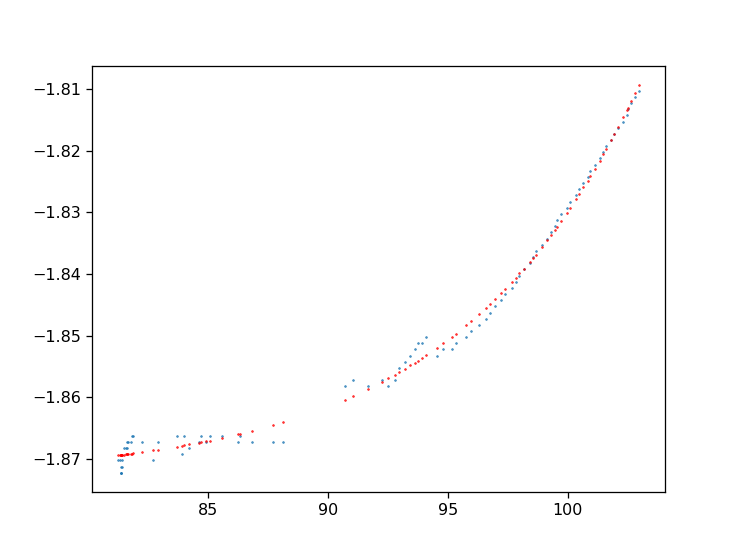

In [19]:
fig3, ax3 = plt.subplots()
# ax3.plot(lowT_df['T'], a*np.exp(b*lowT_df['TypeC_calib_mV']), 'o',ms='0.5')
ax3.plot(lowT_df['T'], lowT_df['TypeC_calib_mV'], 'o',ms='0.5')
ax3.plot(lowT_df['T'], expfunc, 'o',ms='0.5',color='r')

This appears to be a better fit than the polynomial in this regime. Now lets concatenate these two functions and interpolate near the points around 100 K to smooth things out if necessary. Recall that the two functions are fit_poly and expfunc

<IPython.core.display.Javascript object>


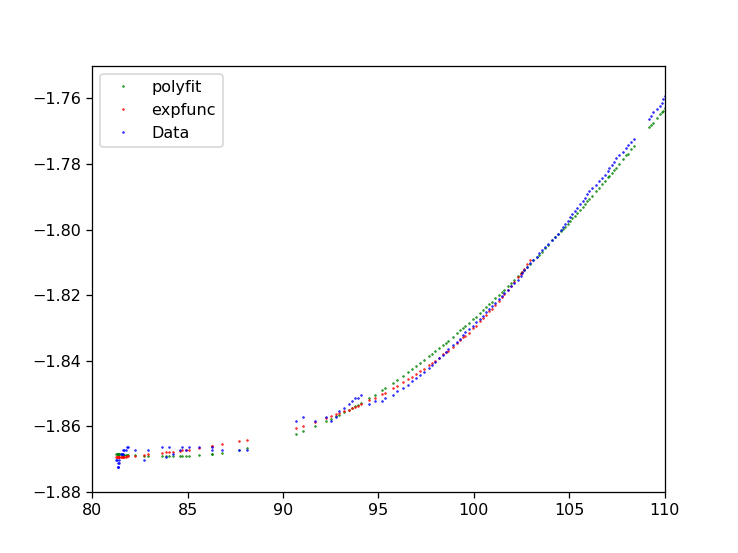

In [20]:
# select data from 103 to 120 K just so we can see the point of intersection a little better
checkT_df = df.query('77<=T<=120') 
fig4, ax4 = plt.subplots()
ax4.plot(checkT_df['T'], fit_poly(checkT_df['T']), 'o', ms=0.5, label='polyfit', color='g')
ax4.plot(lowT_df['T'], expfunc, 'o', ms=0.5, label='expfunc', color='r')
ax4.plot(df['T'], df['TypeC_calib_mV'],'o',ms='0.5', label='Data', color='b')
ax4.set_xlim([80,110])
ax4.set_ylim([-1.88,-1.75])
ax4.legend()

The two fitted plots almost match near 103 K, but there is a little 'cusp'-like shape near the point of intersection. Let's smooth it out. Also, notice that the expfunc fit is a little better than the polyfit.

<IPython.core.display.Javascript object>


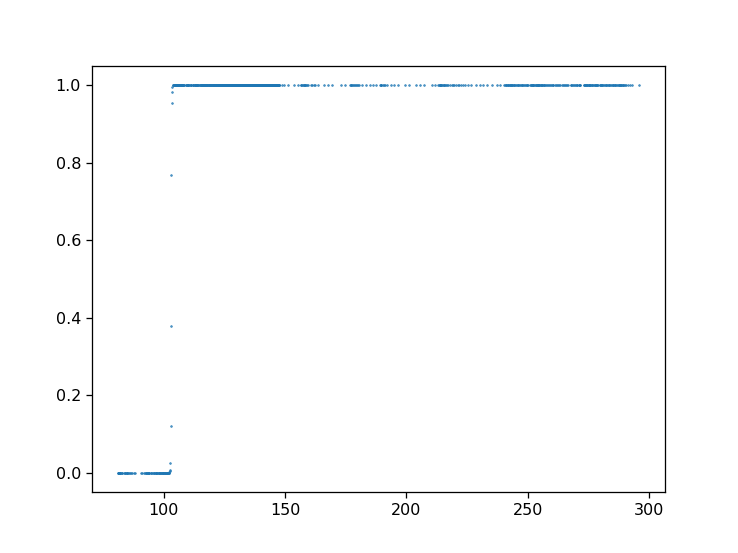

In [21]:
def switch_fcn(x, switchpoint, smooth):
    s = 0.5 + 0.5*np.tanh((x - switchpoint)/smooth)
    return s
sw = switch_fcn(df['T'], 103, 0.2)
expfunc2 = func(df['T'],a,b,c,d)
len(expfunc2)

fig, ax = plt.subplots()
ax.plot(df['T'], sw,'o', ms=0.5)


<IPython.core.display.Javascript object>


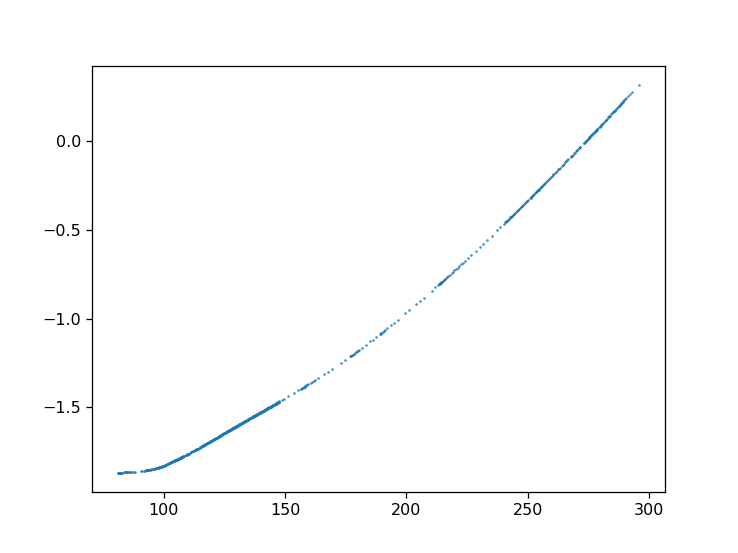

In [22]:
def combined(switch, low_f1, high_f2):
    comb = (1-switch)*low_f1 + switch*high_f2
    return comb
comb_fcn = combined(sw, expfunc2,fit_poly(df['T']))
fig, ax = plt.subplots()
ax.plot(df['T'], comb_fcn, 'o', ms=0.5)

<IPython.core.display.Javascript object>


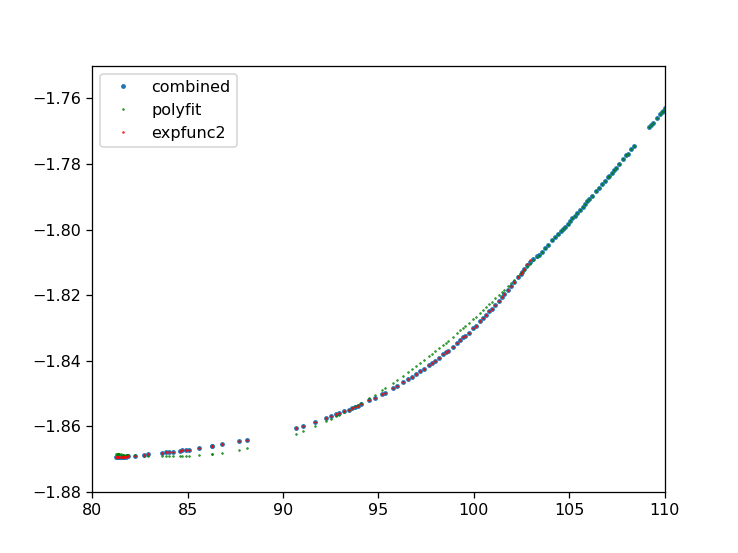

In [23]:
fig5, ax5 = plt.subplots()
ax5.plot(df['T'],comb_fcn, 'o', ms=2, label='combined')
ax5.plot(checkT_df['T'], fit_poly(checkT_df['T']), 'o', ms=0.5, label='polyfit', color='g')
ax5.plot(lowT_df['T'], expfunc, 'o', ms=0.5, label='expfunc2', color='r')
ax5.set_xlim([80,110])
ax5.set_ylim([-1.88,-1.75])
ax5.legend()

Now I will take the polynomial and take the values from 77 K to 273 K for calibration and append them to the NIST values

In [24]:
# low temperature array
low_temp = np.arange(77.15,273.15, 0.1)
# low_temp_calib = fit_poly(low_temp)
low_temp_calib = combined(switch_fcn(low_temp, 103, 3), func(low_temp,a,b,c,d), fit_poly(low_temp))

# high temperature array
high_temp = np.arange(273.15,2588.15, 0.1)
high_temp_nist = typeC.emf_mVK(high_temp)

# concatentate and put into a dataframe and output to excel
Temperature = np.concatenate([low_temp, high_temp])
TypeC_mV = np.concatenate([low_temp_calib, high_temp_nist])

typeC_calibration = pd.DataFrame(data=TypeC_mV, index=Temperature, dtype='float32', columns = ['Type C (mV)'])
typeC_calibration.index.name = 'Temperature (Kelvin)'

print(typeC_calibration.head())
print(typeC_calibration.tail())

                      Type C (mV)
Temperature (Kelvin)             
77.15                   -1.870959
77.25                   -1.870931
77.35                   -1.870902
77.45                   -1.870872
77.55                   -1.870843
                      Type C (mV)
Temperature (Kelvin)             
2587.65                 37.056717
2587.75                 37.057632
2587.85                 37.058548
2587.95                 37.059464
2588.05                 37.060379


In [25]:
# Uncomment these lines and run the cell to output a calibration table
# write to excel

# xlwrite = pd.ExcelWriter('Type C calibration_low_res.xlsx')
# typeC_calibration.to_excel(xlwrite)
# xlwrite.save()

But wait! Suppose we also want to fix that discontinuity at 273.15 K? We can apply the same procudure as before.
1. Apply a tanh(x) function:  $switch = 0.5 + 0.5*np.tanh((x - switchpoint)/smooth)$
2. Combine both functions:  $comb = (1-switch)*f1 + (switch)*f2 $

In [26]:

low_calib = combined(switch_fcn(Temperature, 103, 3), func(Temperature,a,b,c,d), fit_poly(Temperature))

high_calib = pd.DataFrame(index=high_temp, data=high_temp_nist,columns=['mV'])
dummy_df = pd.DataFrame(index=low_temp, data=np.zeros(len(low_temp)),columns=['mV'])
concat_high_calib = dummy_df.append(high_calib)
print(concat_high_calib.loc[272.9:273.5])

freezept_calib = combined(switch_fcn(Temperature, 273.15, 0.45), low_calib, concat_high_calib['mV'] )
freezept_calib.index.name = 'T'

              mV
272.95  0.000000
273.05  0.000000
273.15  0.000000
273.25  0.001339
273.35  0.002678
273.45  0.004017


In [27]:
freezept_calib.loc[272.9:273.5]

T
272.95   -0.008172
273.05   -0.006156
273.15   -0.004336
273.25   -0.002013
273.35    0.000205
273.45    0.002266
Name: mV, dtype: float64

The prior value at 273.15 K was -0.00867, when the actual value is 0. After the smoothing, the new value is -0.004336, about half of the prior value. Some of the values a little after 273.15 do not match exactly with the NIST table, but it is much better than the jump that we had before.

<IPython.core.display.Javascript object>


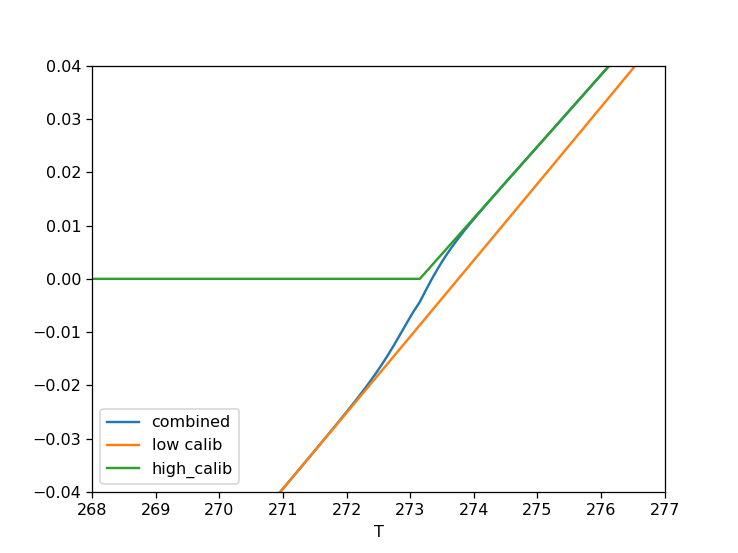

In [28]:
fig, ax = plt.subplots()
freezept_calib.plot(ax=ax, label ='combined')
ax.plot(Temperature,low_calib, label = 'low calib')
ax.plot(Temperature,concat_high_calib, label= 'high_calib')
ax.set_ylim([-.04,0.04])
ax.set_xlim([268,277])
ax.legend()

In [29]:
print(signal.argrelmin(freezept_calib.values))
# print(signal.argrelextrema(freezept_calib.values,np.less))
# print(signal.argrelextrema(freezept_calib.values,np.greater))
# No local maxima or minima!

(array([], dtype=int64),)


<IPython.core.display.Javascript object>


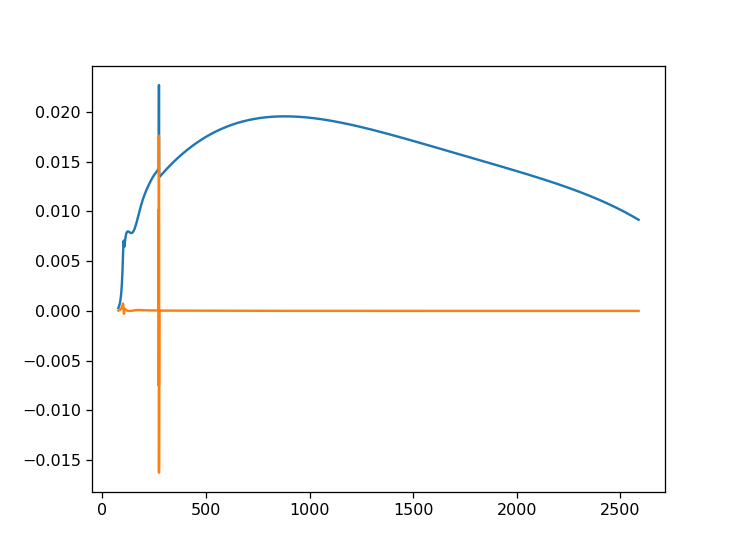

array([  1.88131088e-05,   2.83440425e-05,   3.81253795e-05,
         3.86294970e-05,   3.91402800e-05])

In [45]:
# How about candidates for inflection points?

df = np.gradient(freezept_calib,0.1,)
fig, ax = plt.subplots()
ax.plot(Temperature, df)

d2f = np.gradient(df, 0.1)
ax.plot(Temperature, d2f)

d2f[:5]

In [30]:
# Uncomment these lines and run the cell to output a calibration table
# write to excel

xlwrite = pd.ExcelWriter('Type C calibration_corrected.xlsx')
# freezept_calib is a Series, not a Dataframe, so use the line below
freezept_calib.to_frame().to_excel(xlwrite)
xlwrite.save()